In [27]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.preprocessing import LabelEncoder
sb.set() # set the default Seaborn style for graphics

# Data preparation and cleaning

In [74]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
round (data.describe(exclude = 'object'), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


In [4]:
round (data.describe(exclude = ['int64', 'float']), 2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


Turn all the 0 and 1 categorical variables into booleans:

In [5]:
data["stroke"] = data["stroke"].astype(bool)
data["hypertension"] = data["hypertension"].astype(bool)
data["heart_disease"] = data["heart_disease"].astype(bool)

## Hypertension

In [39]:
data["hypertension"].value_counts()

hypertension
False    4612
True      498
Name: count, dtype: int64

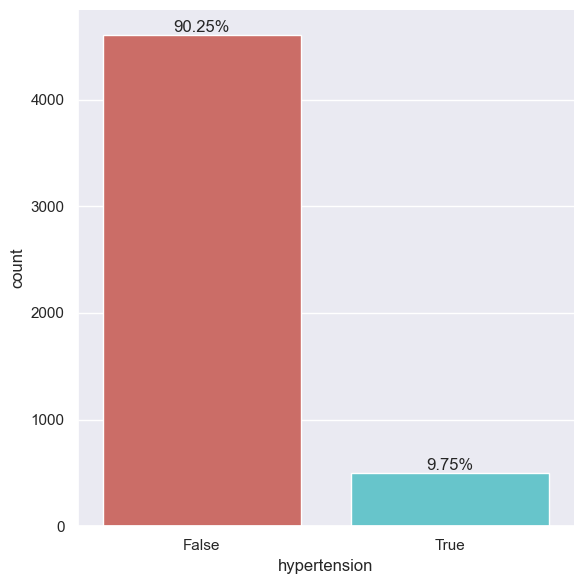

In [6]:
f = sb.catplot(x = "hypertension", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "hypertension")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Heart disease

In [38]:
data["heart_disease"].value_counts()

heart_disease
False    4834
True      276
Name: count, dtype: int64

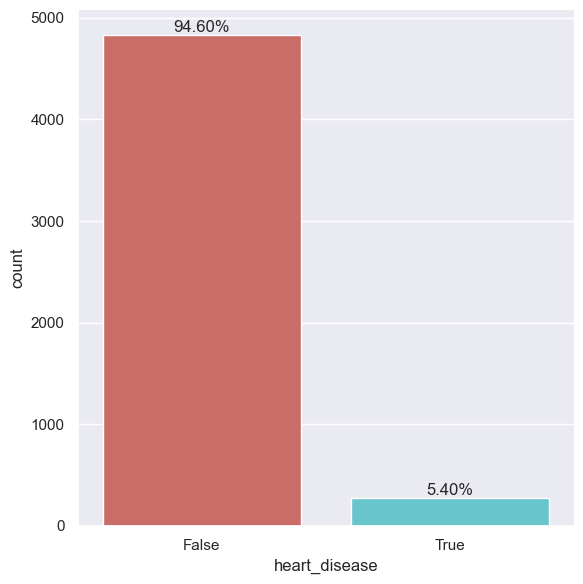

In [37]:
f = sb.catplot(x = "heart_disease", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "heart_disease")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Gender

In [25]:
data[["gender"]].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

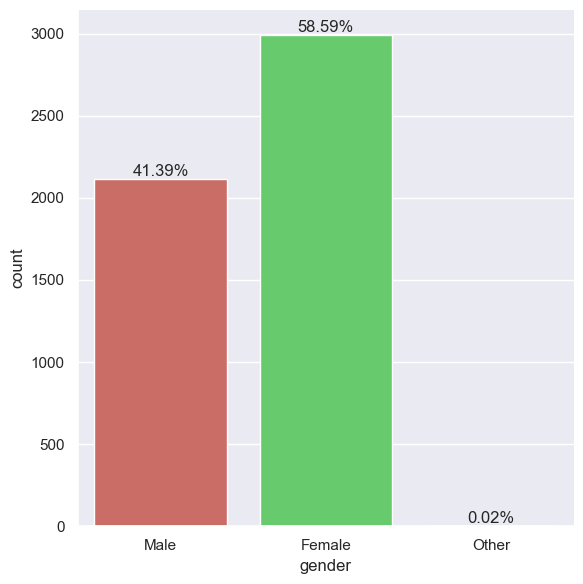

In [7]:
f = sb.catplot(x = "gender", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "gender")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [28]:
gender = pd.DataFrame(data[["gender"]])

for i in gender:
    others = gender[(gender[i] == "Other")]
    gender_data = gender.drop(others.index)

label = LabelEncoder()
gender_data["gender"] = label.fit_transform(gender_data["gender"].astype("str"))

gender_data.value_counts()

gender
0         2994
1         2115
Name: count, dtype: int64

<span style="color:red"> Note that 0: Female, 1: Male </span>

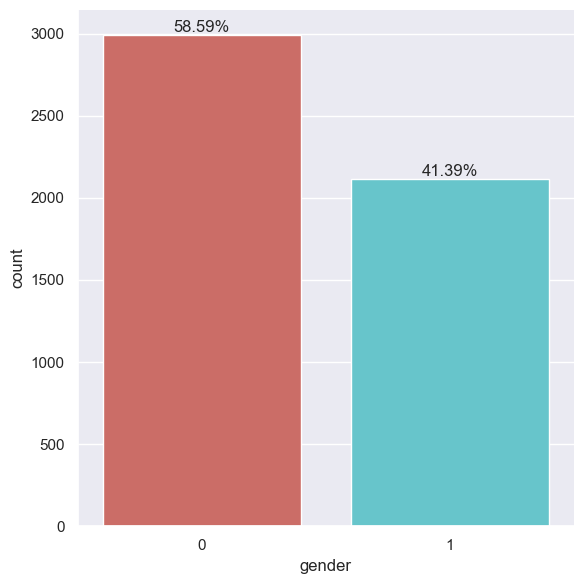

In [29]:
f = sb.catplot(x = "gender", data = gender_data, kind = "count", height=6, palette="hls", legend=False, hue = "gender")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Residence type

In [31]:
data[["Residence_type"]].value_counts()

Residence_type
Urban             2596
Rural             2514
Name: count, dtype: int64

In [33]:
residence_data = pd.DataFrame(data[["Residence_type"]])

residence_data["Residence_type"] = label.fit_transform(residence_data["Residence_type"].astype("str"))

residence_data.value_counts()

Residence_type
1                 2596
0                 2514
Name: count, dtype: int64

<span style="color:red"> Note: 0: Rural, 1: Urban </span>

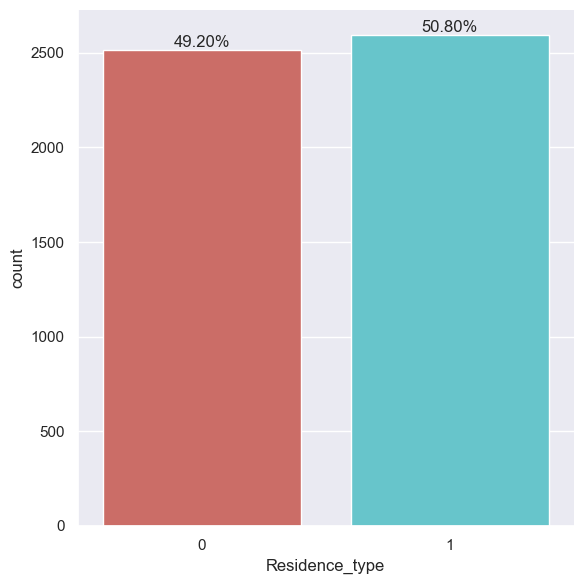

In [36]:
f = sb.catplot(x = "Residence_type", data = residence_data, kind = "count", height=6, palette="hls", legend=False, hue = "Residence_type")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

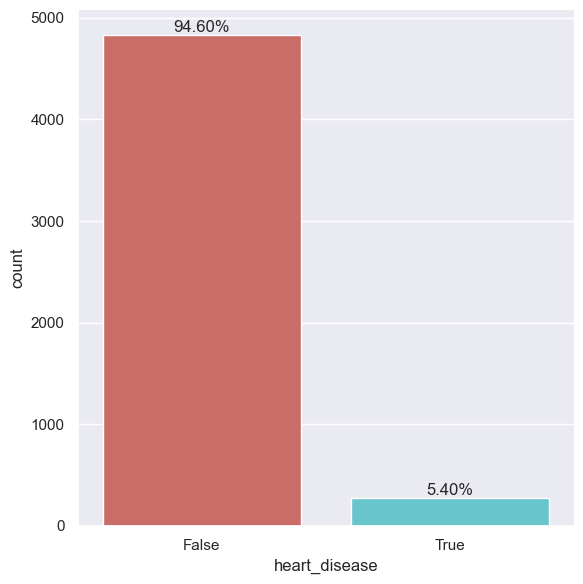

In [9]:
f = sb.catplot(x = "heart_disease", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "heart_disease")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Ever married

In [32]:
data[["ever_married"]].value_counts()

ever_married
Yes             3353
No              1757
Name: count, dtype: int64

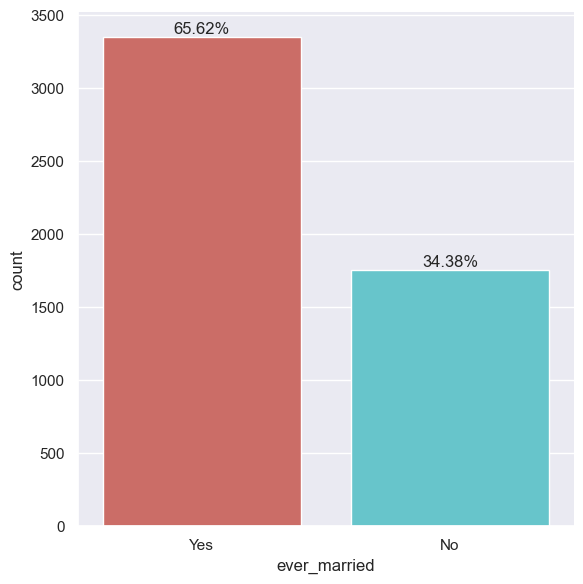

In [10]:
f = sb.catplot(x = "ever_married", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "ever_married")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Smoking status

In [20]:
data["smoking_status"].describe()

count             5110
unique               4
top       never smoked
freq              1892
Name: smoking_status, dtype: object

In [21]:
smoking = pd.DataFrame(data[["smoking_status"]])

for i in smoking:
    unknowns = smoking[(smoking[i] == "Unknown")]
    smoking_data = smoking.drop(unknowns.index)

smoking_data.value_counts()

smoking_status 
never smoked       1892
formerly smoked     885
smokes              789
Name: count, dtype: int64

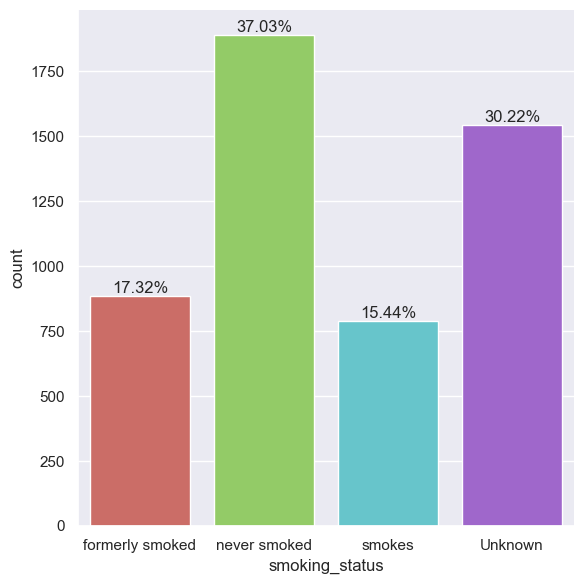

In [11]:
f = sb.catplot(x = "smoking_status", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "smoking_status")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [22]:
sdata = smoking_data.replace('never smoked', 0)
clean_smoking_data = sdata.replace(['formerly smoked', 'smokes'], 1)

clean_smoking_data.value_counts()

C:\Users\thous\AppData\Local\Temp\ipykernel_7016\1298153781.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_smoking_data = sdata.replace(['formerly smoked', 'smokes'], 1)


smoking_status
0                 1892
1                 1674
Name: count, dtype: int64

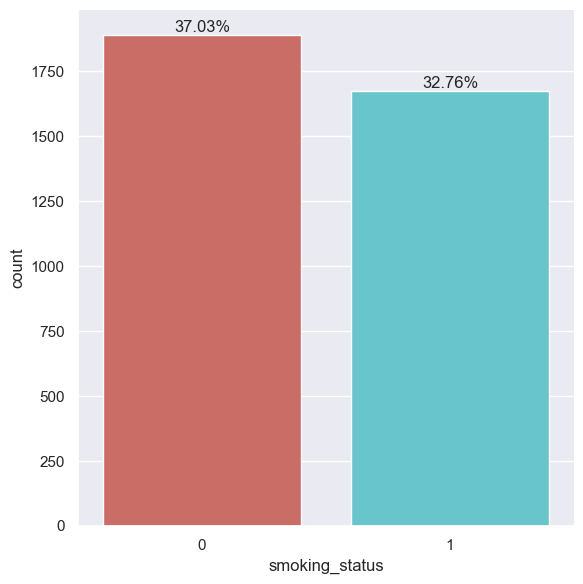

In [24]:
f = sb.catplot(x = "smoking_status", data = clean_smoking_data, kind = "count", height=6, palette="hls", legend=False, hue = "smoking_status")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Work type

In [30]:
data[["work_type"]].value_counts()

work_type    
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

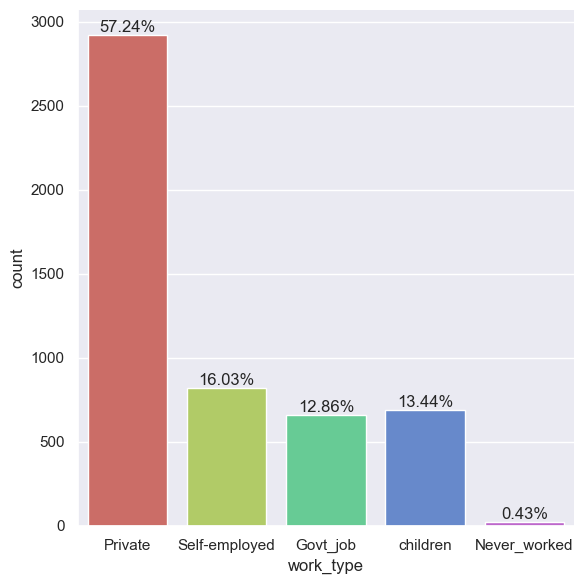

In [12]:
f = sb.catplot(x = "work_type", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "work_type")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Numerical data cleaning (Glucose, BMI, Age)

In [14]:
def RemoveOutliers(data):
    for i in data:
        q1 = data[i].describe(include='all').loc['25%']
        q3 = data[i].describe(include='all').loc['75%']
        IQR = q3 - q1
        btmThresh = q1 - 1.5 * IQR
        topThresh = q3 + 1.5 * IQR
        outliers = data[(data[i] < btmThresh) | (data[i] > topThresh)]
        print('Removed', len(outliers), 'outliers from', i)
        cleandata = data.drop(outliers.index)
        return cleandata

In [71]:
glucose = pd.DataFrame(data[["avg_glucose_level"]])
bmi = pd.DataFrame(data[["bmi"]])
age_data = pd.DataFrame(data[["age"]])

bmi.dropna()

data[["avg_glucose_level"]] = RemoveOutliers(data[["avg_glucose_level"]])
data[["bmi"]] = RemoveOutliers(data[["bmi"]])

Removed 0 outliers from avg_glucose_level
Removed 13 outliers from bmi


<Axes: >

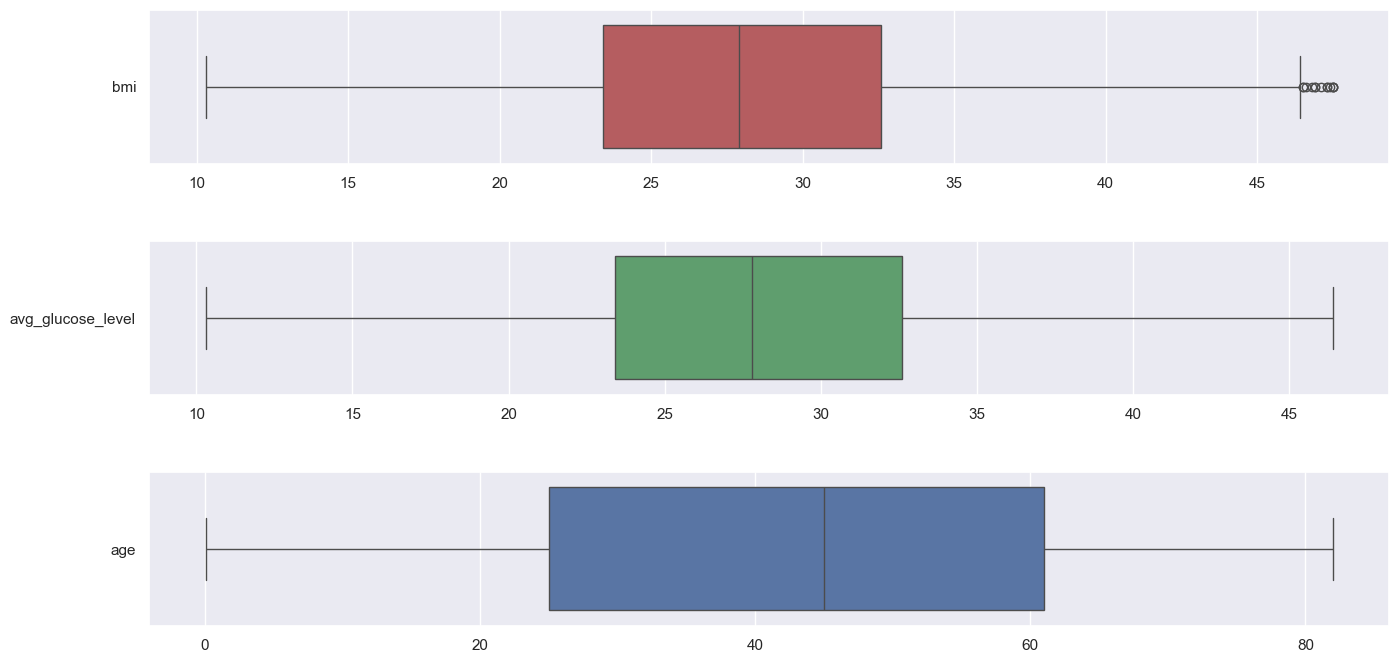

In [72]:
f, axes= plt.subplots(3, 1, figsize=(16, 8))

plt.subplots_adjust(hspace=0.5)
sb.boxplot(data=bmi, orient="h", color="r", ax=axes[0])
sb.boxplot(data=glucose, color="g", orient="h", ax=axes[1])
sb.boxplot(data=age_data, orient="h", color="b", ax=axes[2])

<Axes: >

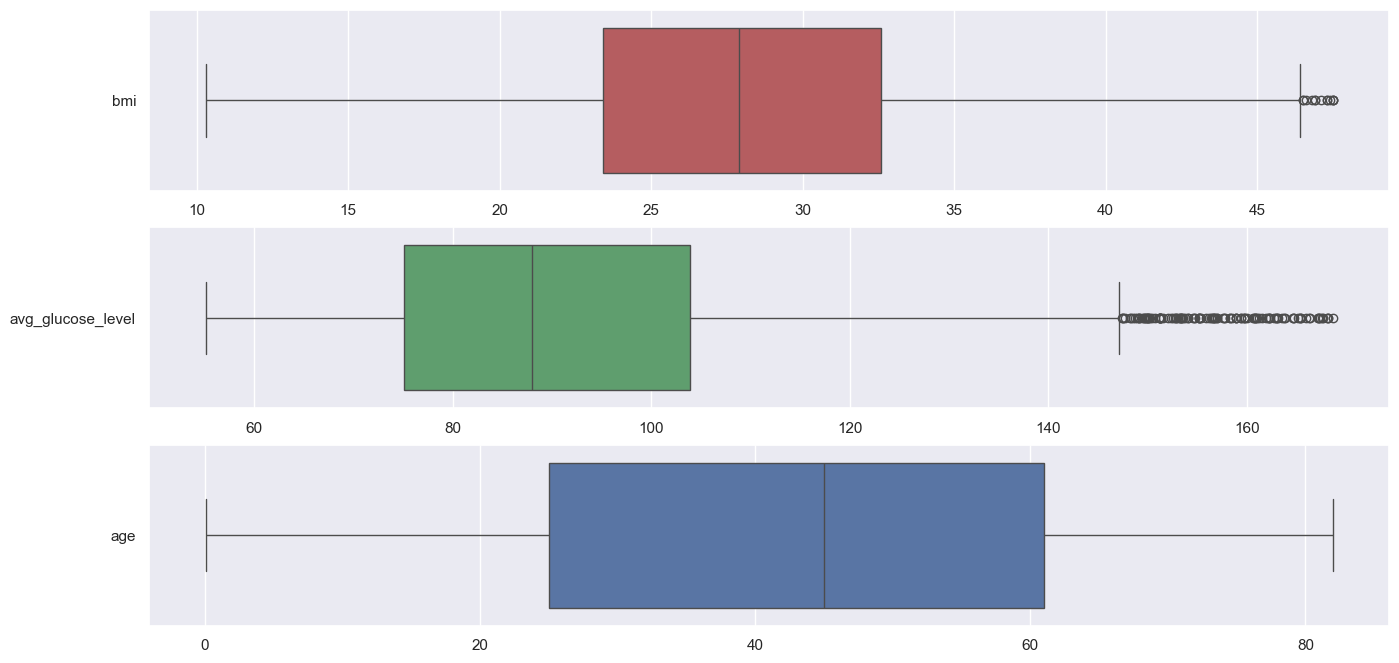

In [73]:
f, axes= plt.subplots(3, 1, figsize=(16, 8))
sb.boxplot(data=bmi_data, orient="h", color="r", ax=axes[0])
sb.boxplot(data=glucose_data, color="g", orient="h", ax=axes[1])
sb.boxplot(data=age_data, orient="h", color="b", ax=axes[2])

## % of responses with stroke

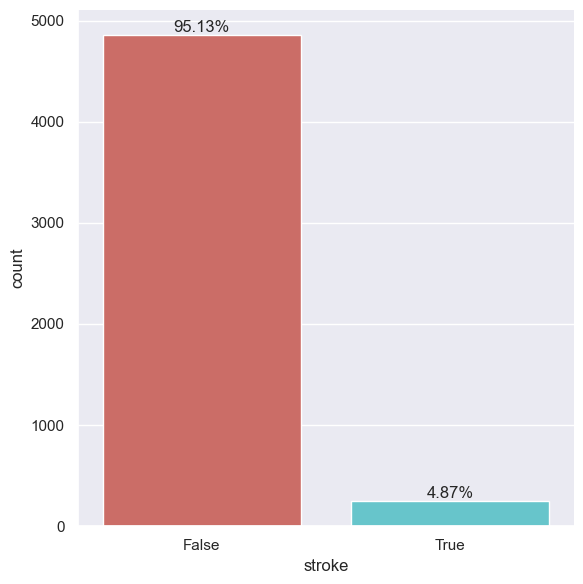

In [17]:
f = sb.catplot(x = "stroke", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "stroke")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Exploratory Data Analysis

## Numerical Data

In [75]:
numdata = pd.DataFrame(data[["avg_glucose_level", "bmi", "age", "stroke"]])

numdata = numdata.dropna()

numdata.describe()

,avg_glucose_level,bmi,age,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000
mean,105.305150,28.893237,42.865374,0.042575
std,44.424341,7.854067,22.555115,0.201917
min,55.120000,10.300000,0.080000,0.000000
25%,77.070000,23.500000,25.000000,0.000000
50%,91.680000,28.100000,44.000000,0.000000
75%,113.570000,33.100000,60.000000,0.000000
max,271.740000,97.600000,82.000000,1.000000


<Axes: >

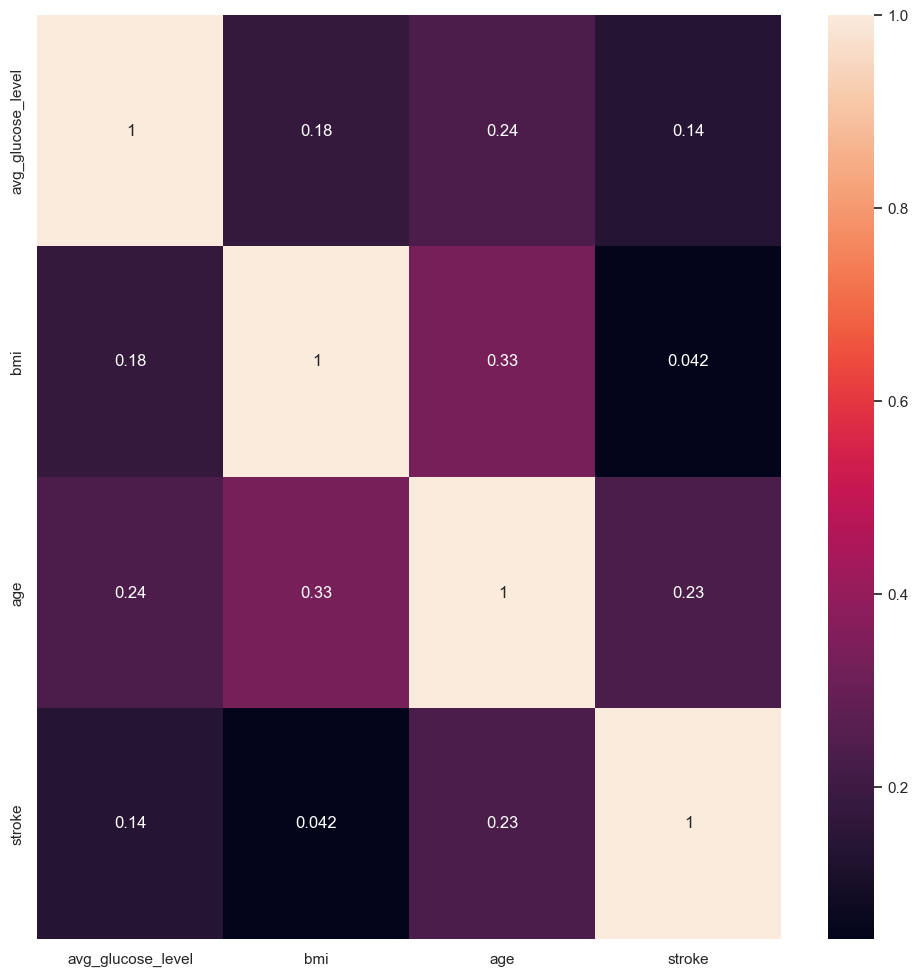

In [76]:
f = plt.figure(figsize=(12,12))
sb.heatmap(numdata.corr(), annot=True)